In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import copy
import pickle

import sys
sys.path.append('./../../')
sys.path.append('./../../../designer/script')
sys.path.append('./../../../')

from film import TwoMaterialFilm
from spectrum import SpectrumSimple
from optimizer.adam import AdamThicknessOptimizer
from utils.substitute import equal_optical_thickness_new, optimal_and_thin_film_approx_substitution_onestep_new
from utils.loss import calculate_RMS
from analyze_utils.result_io import save, load

In [21]:
rep = 50
thin_layer_nums = [2, 10, 20]
thin_thickness = 1.

layer_num = 100
layer_avg = 100
layer_var = 20



def exp_sub_and_gd(original_film: TwoMaterialFilm, sub_func, gd=True):
    to_change_film = copy.deepcopy(original_film)
    sub_func(to_change_film, thin_thickness + 1.)
    loss_after_sub = calculate_RMS(original_film, to_change_film)
    if not gd:
        return loss_after_sub
    optimizer = AdamThicknessOptimizer(
        to_change_film, 
        original_film.get_all_spec_list(), 
        max_steps=20, 
        alpha=0.1, 
        record=False, 
        show=False,
    )
    optimizer()
    loss_after_gd = calculate_RMS(original_film, to_change_film)

    return [loss_after_sub, loss_after_gd]

In [22]:

losses_eqot_rep = []
losses_optim_rep = []

for i in range(rep):
    print(i / rep)
    losses_eqot_rep.append([])
    losses_optim_rep.append([])
    for thin_layer_num in thin_layer_nums:
        np.random.seed()

        d = np.random.random(layer_num) * layer_var + layer_avg
        # randomly select layers to set to thin.
        idx = np.arange(1, layer_num - 1) # except last layer
        np.random.shuffle(idx)
        thin_idx = idx[:thin_layer_num]
        d[thin_idx] = thin_thickness

        film = TwoMaterialFilm(1.5, 2.5, 1.5, d)
        film.add_spec_param(inc_ang=60., wls=np.linspace(500, 1000, 500))

        losses_eqot_rep[-1].append(exp_sub_and_gd(film, equal_optical_thickness_new))
        losses_optim_rep[-1].append(exp_sub_and_gd(film, optimal_and_thin_film_approx_substitution_onestep_new))
save(f'./substitute_results/after_gd_20layers_110+-20nm_thinlayer_5_10_20_rep{rep}', losses_eqot_rep, losses_optim_rep)

0.0


/home/vipuser/miniconda3/envs/tf_design_2/lib/python3.10/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/vipuser/miniconda3/envs/tf_design_2/lib/python3.10/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/root/Thin-Film-Design/working/review/substitution/./../../../designer/script/utils/substitute.py:197: ComplexWarning: Casting complex values to real discards the imaginary part
  arr[:, 1, 0] = a10
/root/Thin-Film-Design/working/review/substitution/./../../../designer/script/utils/substitute.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  arr[:, 0, 1] = a01


0.02
0.04
0.06
0.08
0.1
0.12
0.14
0.16
0.18
0.2
0.22
0.24
0.26
0.28
0.3
0.32
0.34
0.36
0.38
0.4
0.42
0.44
0.46
0.48
0.5
0.52
0.54
0.56
0.58
0.6
0.62
0.64
0.66
0.68
0.7
0.72
0.74
0.76
0.78
0.8
0.82
0.84
0.86
0.88
0.9
0.92
0.94
0.96
0.98


In [23]:
losses_eqot_rep, losses_optim_rep = load(f'./substitute_results/after_gd_20layers_110+-20nm_thinlayer_5_10_20_rep{rep}')

eqot_after_sub = np.array(losses_eqot_rep)[:, :, 0]
eqot_after_gd = np.array(losses_eqot_rep)[:, :, 1]

optim_after_sub = np.array(losses_optim_rep)[:, :, 0]
optim_after_gd = np.array(losses_optim_rep)[:, :, 1]

#### Violin Plot

(10, 3) 3
(10, 3) 3
(10, 3) 3
(10, 3) 3
(10, 3) 3
(10, 3) 3


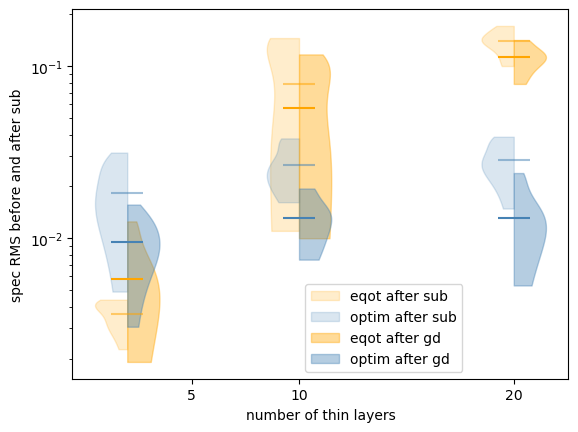

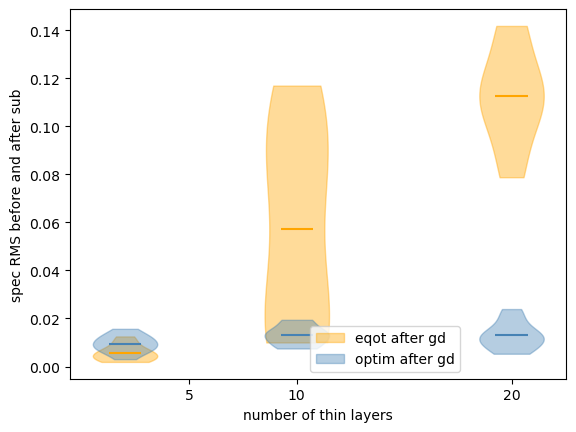

In [16]:
from analyze_utils.color import blue_sequential, green_sequential, pink_sequential


def plot_rep_violin(ax, x, arr, label, c, alpha=0.5, edge_alpha=None, zorder=None, left=False, right=False):
    print(arr.shape, len(x))
    arr_ls = [arr[:, i] for i in range(arr.shape[1])]
    s = ax.violinplot(
        arr_ls, 
        x, 
        widths=3, 
        showmedians=False,
        showmeans=True, 
        showextrema=False, 
        points=1000
    )

    # for partname in ('cbars','cmins','cmaxes', 'cmeans'):
    for partname in ('cmeans', ):
        vp = s[partname]
        vp.set_edgecolor(c)
        if edge_alpha is not None:
            vp.set_alpha(edge_alpha)
        # vp.set_linewidth(1)



    for pc in s['bodies']:
        pc.set_facecolor(c)
        pc.set_edgecolor(c)
        if alpha is not None:
            pc.set_alpha(alpha)

        # get the center
        m = np.mean(pc.get_paths()[0].vertices[:, 0])
        if right:
            # modify the paths to not go further left than the center
            pc.get_paths()[0].vertices[:, 0] = np.clip(pc.get_paths()[0].vertices[:, 0], m, np.inf)
        if left:
            # modify the paths to not go further left than the center
            pc.get_paths()[0].vertices[:, 0] = np.clip(pc.get_paths()[0].vertices[:, 0], -np.inf, m)
    
    return mpatches.Patch(
        color=s['bodies'][0].get_facecolor().flatten(), 
        label=label
    )

# plot log
fig, ax = plt.subplots(1, 1)
labels = []
labels.append(plot_rep_violin(ax, thin_layer_nums, eqot_after_sub, label='eqot after sub', alpha=0.2, edge_alpha=0.5, c='orange', left=True,))
labels.append(plot_rep_violin(ax, thin_layer_nums, optim_after_sub, label='optim after sub', alpha=0.2, edge_alpha=0.5, c='steelblue', left=True,))

labels.append(plot_rep_violin(ax, thin_layer_nums, eqot_after_gd, label='eqot after gd', alpha=0.4, c='orange', right=True))
labels.append(plot_rep_violin(ax, thin_layer_nums, optim_after_gd, label='optim after gd', alpha=0.4, c='steelblue', right=True))

ax.set_xlabel('number of thin layers')
ax.set_ylabel('spec RMS before and after sub')
ax.set_xticks([5, 10, 20])

ax.set_yscale('log')
ax.legend(handles=labels, loc='lower right', bbox_to_anchor=(0.8, 0))
# fig.savefig('./figs/sub_and_GD_dif_number_log.png', dpi=300)

# plot linear
fig, ax = plt.subplots(1, 1)
labels = []
# labels.append(plot_rep_violin(ax, thin_layer_nums, eqot_after_sub, label='eqot after sub', c=green_sequential()[0], left=True, right=True))
# labels.append(plot_rep_violin(ax, thin_layer_nums, optim_after_sub, label='optim after sub', c=blue_sequential()[0], left=True, right=True))

labels.append(plot_rep_violin(ax, thin_layer_nums, eqot_after_gd, label='eqot after gd', alpha=0.4, c='orange', right=False))
labels.append(plot_rep_violin(ax, thin_layer_nums, optim_after_gd, label='optim after gd', alpha=0.4, c='steelblue', right=False))

ax.set_xlabel('number of thin layers')
ax.set_ylabel('spec RMS before and after sub')
ax.set_xticks([5, 10, 20])

# ax.set_ylim(0, 1e-2)
ax.legend(handles=labels, loc='lower right', bbox_to_anchor=(0.8, 0))
# fig.savefig('./figs/sub_and_GD_dif_number_linear.png', dpi=300)

#### 2d hist

using new fig


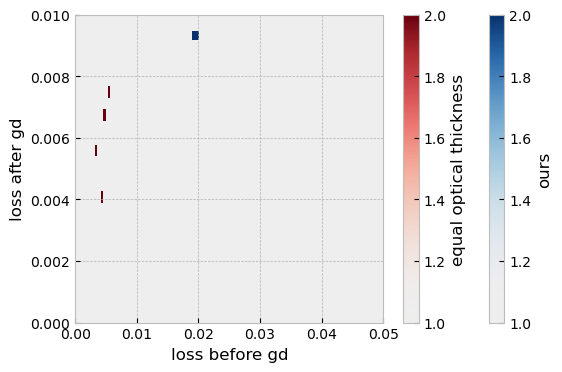

In [24]:
nlayers_id = 0
layers = [5, 10, 20]
xymaxs = [(0.05, 0.01), (0.05, 0.01), (0.05, 0.01)]
bins_xy = [(20, 20), (20, 20), (20, 20)]


def hists(x, y, label, cmap, fig=None, ax=None, bins=None, log=False):
    xmax, ymax = xymaxs[nlayers_id]
    if not log:
        good_idx = (x < xmax) & (y < ymax)
    else:
        xmin, ymin = xymins[nlayers_id]
        good_idx = (xmin < x) & (x < xmax) & (ymin < y) & (y < ymax)

    x, y = x[good_idx], y[good_idx]
    if fig is None or ax is None:
        print('using new fig')
        fig, ax = plt.subplots(1, 1)
    s = ax.hist2d(
        x, 
        y, 
        bins=30 if bins is None else bins, 
        cmap=cmap, 
        vmin=1, 
    )
    
    ax.set_xlim(xmin if log else 0, xmax)
    ax.set_ylim(ymin if log else 0, ymax)
    ax.set_xlabel('log' if log else '' + 'loss before gd')
    ax.set_ylabel('log' if log else '' + 'loss after gd')

    cbar = fig.colorbar(s[-1])
    cbar.set_label(label)

    return fig, ax

def get_fading(cm):
    fading_x = cm(np.arange(cm.N)) # extract colors
    fading_x[:, -1] = np.linspace(0, 1, cm.N) # modify alpha
    from matplotlib.colors import ListedColormap
    fading_x = ListedColormap(fading_x) # convert to colormap
    return fading_x

fading_red = get_fading(plt.cm.Reds)  # original colormap
fading_blue = get_fading(plt.cm.Blues)

with plt.style.context('bmh'):
    fig, ax = hists(optim_after_sub[:, nlayers_id], optim_after_gd[:, nlayers_id], 'ours', fading_blue, bins=bins_xy[nlayers_id][0])
    hists(eqot_after_sub[:, nlayers_id], eqot_after_gd[:, nlayers_id], 'equal optical thickness', fading_red, fig=fig, ax=ax, bins=bins_xy[nlayers_id][1])
    ax.set_aspect(5)
    fig.set_size_inches(6.5, 4)
    fig.savefig(f'./figs/sub_and_gd_hist2d_{layers[nlayers_id]}_layers.png', dpi=300)
    plt.show()

using new fig


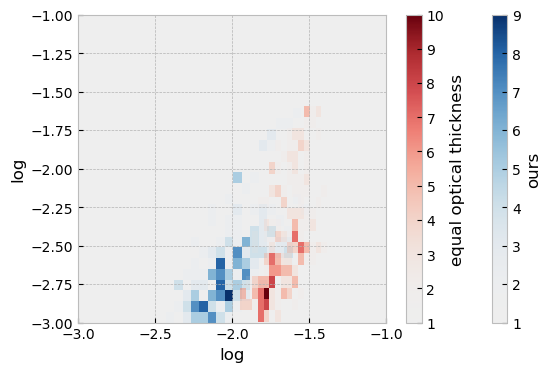

In [27]:
# log
nlayers_id = 0
xymaxs = [(-1, -1), (-1, -1), (-1, -1),]
xymins = [(-3, -3), (-3, -3), (-3, -3)]
bins_xy = [(20, 20), (20, 20), (20, 20)]

with plt.style.context('bmh'):

    fig, ax = hists(np.log10(optim_after_sub[:, nlayers_id]), np.log10(optim_after_gd[:, nlayers_id]), 'ours', fading_blue, bins=bins_xy[nlayers_id][0], log=True)
    hists(np.log10(eqot_after_sub[:, nlayers_id]), np.log10(eqot_after_gd[:, nlayers_id]), 'equal optical thickness', fading_red, fig=fig, ax=ax, bins=bins_xy[nlayers_id][1], log=True)
    ax.set_aspect(1)
    fig.set_size_inches(6.5, 4)

    fig.savefig(f'./figs/sub_and_gd_hist2d_{layers[nlayers_id]}_layers_log.png', dpi=300)
    plt.show()

#### ?

In [16]:
def scan_layer_and_ot():
    rep = 10
    thin_layer_nums = np.arange(1, 10, 1)
    thin_thicknesses = np.linspace(0, 2, 10)
    layer_num = 20
    layer_avg = 50
    losses_eqot_rep = []
    losses_optim_rep = []
    for _ in range(rep):
        losses_eqot_rep.append([])
        losses_optim_rep.append([])
        for thin_thickness in thin_thicknesses:
            losses_eqot_rep[-1].append([])
            losses_optim_rep[-1].append([])
            for thin_layer_num in thin_layer_nums:
                np.random.seed()

                d = np.random.random(layer_num) * layer_var + layer_avg
                # randomly select layers to set to thin.
                idx = np.arange(layer_num - 1) # except layer layer
                np.random.shuffle(idx)
                thin_idx = idx[:thin_layer_num]
                d[thin_idx] = thin_thickness

                film = TwoMaterialFilm(1.5, 2.5, 1.5, d)
                film.add_spec_param(inc_ang=60., wls=np.linspace(500, 1000, 500))

                losses_eqot_rep[-1][-1].append(exp_sub_and_gd(film, equal_optical_thickness_new, gd=False))
                losses_optim_rep[-1][-1].append(exp_sub_and_gd(film, optimal_and_thin_film_approx_substitution_onestep_new, gd=False))
    return losses_eqot_rep, losses_optim_rep
losses_eqot_scan_rep, losses_optim_scan_rep = scan_layer_and_ot()
save(f'./substitution_scan', losses_eqot_scan_rep, losses_optim_scan_rep)

Text(0, 0.5, 'layer nums')

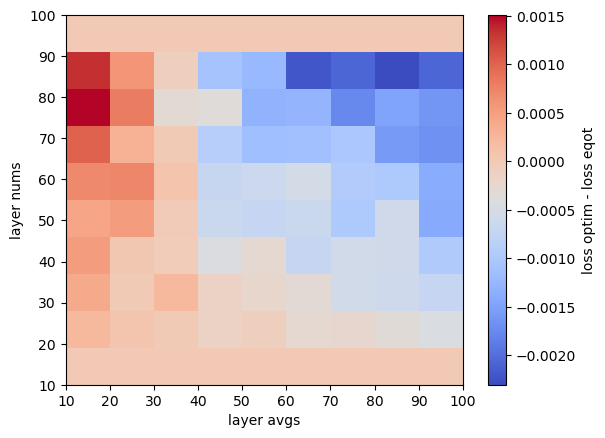

In [17]:
losses_eqot_scan_rep, losses_optim_scan_rep = load('./substitution_scan')
losses_eqot_scan = np.mean(np.array(losses_eqot_scan_rep), axis=0)
losses_optim_scan = np.mean(np.array(losses_optim_scan_rep), axis=0)

fig, ax = plt.subplots(1, 1)
s = ax.imshow(
    losses_optim_scan[:, :] - losses_eqot_scan[:, :], 
    cmap='coolwarm', 
    extent=[10, 100, 100, 10], 
    aspect='auto', 
    # vmax=0, 
    # vmin=-0
)

ax.invert_yaxis()
cbar = fig.colorbar(s)
cbar.set_label('loss optim - loss eqot')
ax.set_xlabel('layer avgs')
ax.set_ylabel('layer nums')